# MLP 220
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=4
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP220'
NEURONS=16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP220.model/assets
Data prep
Data reshape


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4409 - accuracy: 0.7972 - val_loss: 0.4315 - val_accuracy: 0.8026
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3817 - accuracy: 0.8345 - val_loss: 0.3464 - val_accuracy: 0.8535
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3740 - accuracy: 0.8363 - val_loss: 0.3578 - val_accuracy: 0.8461
Epoch 4/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3681 - accuracy: 0.8432 - val_loss: 0.3289 - val_accuracy: 0.8622
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3685 - accuracy: 0.8405 - val_loss: 0.3312 - val_accuracy: 0.8585
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3666 - accuracy: 0.8441 - val_loss: 0.3441 - val_accuracy: 0.8566
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3626 - accuracy: 0.843

453/453 [==============================] - 1s 2ms/step - loss: 0.3152 - accuracy: 0.8677 - val_loss: 0.3064 - val_accuracy: 0.8721
Epoch 46/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3142 - accuracy: 0.8674 - val_loss: 0.3136 - val_accuracy: 0.8740
Epoch 47/200
453/453 [==============================] - 2s 5ms/step - loss: 0.3117 - accuracy: 0.8680 - val_loss: 0.3033 - val_accuracy: 0.8759
Epoch 48/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3109 - accuracy: 0.8693 - val_loss: 0.3103 - val_accuracy: 0.8721
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3119 - accuracy: 0.8677 - val_loss: 0.3025 - val_accuracy: 0.8727
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3090 - accuracy: 0.8692 - val_loss: 0.3015 - val_accuracy: 0.8746
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3088 - accuracy: 0.8695 - val_loss: 0.3115 - val_accuracy: 0.8765
Epoch

Epoch 101/200
453/453 [==============================] - 2s 4ms/step - loss: 0.2877 - accuracy: 0.8823 - val_loss: 0.3202 - val_accuracy: 0.8616
Epoch 102/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2844 - accuracy: 0.8830 - val_loss: 0.3213 - val_accuracy: 0.8678
Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2814 - accuracy: 0.8841 - val_loss: 0.3048 - val_accuracy: 0.8765
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2819 - accuracy: 0.8826 - val_loss: 0.3128 - val_accuracy: 0.8771
Epoch 105/200
453/453 [==============================] - 2s 3ms/step - loss: 0.2805 - accuracy: 0.8859 - val_loss: 0.3085 - val_accuracy: 0.8771
Epoch 106/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2832 - accuracy: 0.8820 - val_loss: 0.3188 - val_accuracy: 0.8703
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2803 - accuracy: 0.8832 - val_loss: 0.3189 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.2658 - accuracy: 0.8926 - val_loss: 0.3365 - val_accuracy: 0.8591
Epoch 157/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2635 - accuracy: 0.8947 - val_loss: 0.3302 - val_accuracy: 0.8678
Epoch 158/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2659 - accuracy: 0.8911 - val_loss: 0.3241 - val_accuracy: 0.8678
Epoch 159/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2659 - accuracy: 0.8933 - val_loss: 0.3265 - val_accuracy: 0.8734
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2655 - accuracy: 0.8913 - val_loss: 0.3249 - val_accuracy: 0.8740
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2634 - accuracy: 0.8938 - val_loss: 0.3278 - val_accuracy: 0.8715
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2627 - accuracy: 0.8952 - val_loss: 0.3322 - val_accuracy: 0.8572

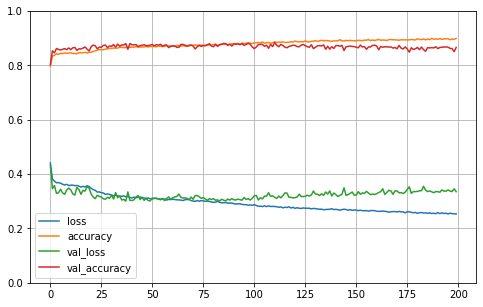

accuracy: 88.39%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4442 - accuracy: 0.7923 - val_loss: 0.4037 - val_accuracy: 0.8268
Epoch 2/200
453/453 [==============================] - 2s 5ms/step - loss: 0.3747 - accuracy: 0.8352 - val_loss: 0.4013 - val_accuracy: 0.8380
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3654 - accuracy: 0.8422 - val_loss: 0.3778 - val_accuracy: 0.8361
Epoch 4/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3604 - accuracy: 0.8433 - val_loss: 0.4478 - val_accuracy: 0.8032
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3578 - accuracy: 0.8465 - val_loss: 0.3814 - val_accuracy: 0.8336
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3625 - accuracy: 0.8439 - val_loss: 0.4611 - val_accuracy: 0.7927
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3607 - accuracy: 0.84

453/453 [==============================] - 1s 2ms/step - loss: 0.2987 - accuracy: 0.8708 - val_loss: 0.3623 - val_accuracy: 0.8547
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2983 - accuracy: 0.8728 - val_loss: 0.3677 - val_accuracy: 0.8541
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2931 - accuracy: 0.8744 - val_loss: 0.3753 - val_accuracy: 0.8492
Epoch 51/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2944 - accuracy: 0.8740 - val_loss: 0.3558 - val_accuracy: 0.8585
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2916 - accuracy: 0.8780 - val_loss: 0.3606 - val_accuracy: 0.8566
Epoch 53/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2926 - accuracy: 0.8745 - val_loss: 0.3631 - val_accuracy: 0.8579
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2919 - accuracy: 0.8779 - val_loss: 0.3676 - val_accuracy: 0.8541
Epoch

Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2572 - accuracy: 0.8926 - val_loss: 0.4154 - val_accuracy: 0.8442
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2569 - accuracy: 0.8901 - val_loss: 0.4069 - val_accuracy: 0.8355
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2565 - accuracy: 0.8906 - val_loss: 0.4050 - val_accuracy: 0.8417
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2569 - accuracy: 0.8919 - val_loss: 0.4415 - val_accuracy: 0.8411
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2578 - accuracy: 0.8899 - val_loss: 0.4061 - val_accuracy: 0.8423
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2573 - accuracy: 0.8893 - val_loss: 0.4219 - val_accuracy: 0.8293
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2554 - accuracy: 0.8909 - val_loss: 0.4108 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.2330 - accuracy: 0.9007 - val_loss: 0.4744 - val_accuracy: 0.8268
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2345 - accuracy: 0.8995 - val_loss: 0.4492 - val_accuracy: 0.8349
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2316 - accuracy: 0.9024 - val_loss: 0.4655 - val_accuracy: 0.8392
Epoch 164/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2330 - accuracy: 0.9035 - val_loss: 0.4776 - val_accuracy: 0.8392
Epoch 165/200
453/453 [==============================] - 2s 3ms/step - loss: 0.2309 - accuracy: 0.9035 - val_loss: 0.4972 - val_accuracy: 0.8330
Epoch 166/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2333 - accuracy: 0.9023 - val_loss: 0.4711 - val_accuracy: 0.8454
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2309 - accuracy: 0.9040 - val_loss: 0.4779 - val_accuracy: 0.8281

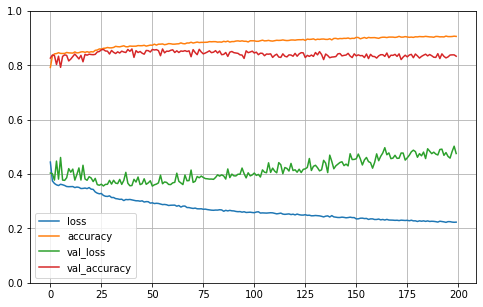

accuracy: 86.03%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4549 - accuracy: 0.7840 - val_loss: 0.3693 - val_accuracy: 0.8467
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3803 - accuracy: 0.8350 - val_loss: 0.3882 - val_accuracy: 0.8380
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3698 - accuracy: 0.8415 - val_loss: 0.3634 - val_accuracy: 0.8547
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3613 - accuracy: 0.8427 - val_loss: 0.4054 - val_accuracy: 0.8218
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3642 - accuracy: 0.8452 - val_loss: 0.3537 - val_accuracy: 0.8529
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3603 - accuracy: 0.8442 - val_loss: 0.3667 - val_accuracy: 0.8485
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3597 - accuracy: 0.84

Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2960 - accuracy: 0.8748 - val_loss: 0.3463 - val_accuracy: 0.8510
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2966 - accuracy: 0.8750 - val_loss: 0.3535 - val_accuracy: 0.8461
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2960 - accuracy: 0.8769 - val_loss: 0.3491 - val_accuracy: 0.8529
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2950 - accuracy: 0.8764 - val_loss: 0.3534 - val_accuracy: 0.8442
Epoch 57/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2937 - accuracy: 0.8765 - val_loss: 0.3583 - val_accuracy: 0.8485
Epoch 58/200
453/453 [==============================] - 2s 4ms/step - loss: 0.2944 - accuracy: 0.8766 - val_loss: 0.3548 - val_accuracy: 0.8516
Epoch 59/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2907 - accuracy: 0.8785 - val_loss: 0.3646 - val_accuracy:

453/453 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.8895 - val_loss: 0.3530 - val_accuracy: 0.8579
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2665 - accuracy: 0.8886 - val_loss: 0.3752 - val_accuracy: 0.8473
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2640 - accuracy: 0.8882 - val_loss: 0.3545 - val_accuracy: 0.8616
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2639 - accuracy: 0.8892 - val_loss: 0.3739 - val_accuracy: 0.8572
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2673 - accuracy: 0.8877 - val_loss: 0.3597 - val_accuracy: 0.8516
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2654 - accuracy: 0.8908 - val_loss: 0.3583 - val_accuracy: 0.8591
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2643 - accuracy: 0.8890 - val_loss: 0.3600 - val_accuracy: 0.8585

453/453 [==============================] - 1s 3ms/step - loss: 0.2407 - accuracy: 0.9013 - val_loss: 0.3872 - val_accuracy: 0.8485
Epoch 162/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2387 - accuracy: 0.8995 - val_loss: 0.4029 - val_accuracy: 0.8516
Epoch 163/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2390 - accuracy: 0.9021 - val_loss: 0.4049 - val_accuracy: 0.8467
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2375 - accuracy: 0.8997 - val_loss: 0.4169 - val_accuracy: 0.8492
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2387 - accuracy: 0.9017 - val_loss: 0.3990 - val_accuracy: 0.8492
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2360 - accuracy: 0.9026 - val_loss: 0.4084 - val_accuracy: 0.8430
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2362 - accuracy: 0.9028 - val_loss: 0.4251 - val_accuracy: 0.8492

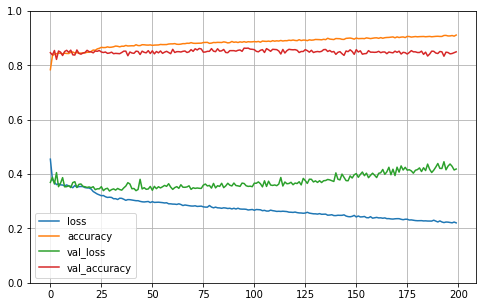

accuracy: 86.34%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4533 - accuracy: 0.7887 - val_loss: 0.3800 - val_accuracy: 0.8355
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3739 - accuracy: 0.8403 - val_loss: 0.3999 - val_accuracy: 0.8218
Epoch 3/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3699 - accuracy: 0.8419 - val_loss: 0.3669 - val_accuracy: 0.8423
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3621 - accuracy: 0.8466 - val_loss: 0.3681 - val_accuracy: 0.8405
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3656 - accuracy: 0.8410 - val_loss: 0.3834 - val_accuracy: 0.8268
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3615 - accuracy: 0.8425 - val_loss: 0.3643 - val_accuracy: 0.8417
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3632 - accuracy: 0.84

Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2957 - accuracy: 0.8740 - val_loss: 0.3449 - val_accuracy: 0.8504
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2904 - accuracy: 0.8770 - val_loss: 0.3595 - val_accuracy: 0.85540s - loss: 0.2894 - accuracy
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2941 - accuracy: 0.8748 - val_loss: 0.3392 - val_accuracy: 0.8535
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2956 - accuracy: 0.8744 - val_loss: 0.3418 - val_accuracy: 0.8547
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2953 - accuracy: 0.8739 - val_loss: 0.3464 - val_accuracy: 0.8529
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2924 - accuracy: 0.8787 - val_loss: 0.3544 - val_accuracy: 0.8535
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2923 - accuracy: 0.8772 - val_

453/453 [==============================] - 1s 3ms/step - loss: 0.2610 - accuracy: 0.8917 - val_loss: 0.3683 - val_accuracy: 0.8411
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.8914 - val_loss: 0.3629 - val_accuracy: 0.8467
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2612 - accuracy: 0.8916 - val_loss: 0.3671 - val_accuracy: 0.8461
Epoch 110/200
453/453 [==============================] - 2s 3ms/step - loss: 0.2613 - accuracy: 0.8922 - val_loss: 0.3722 - val_accuracy: 0.8473
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2603 - accuracy: 0.8922 - val_loss: 0.3842 - val_accuracy: 0.8361
Epoch 112/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2627 - accuracy: 0.8915 - val_loss: 0.3882 - val_accuracy: 0.8430
Epoch 113/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2617 - accuracy: 0.8935 - val_loss: 0.3687 - val_accuracy: 0.8473

453/453 [==============================] - 2s 4ms/step - loss: 0.2430 - accuracy: 0.9022 - val_loss: 0.3968 - val_accuracy: 0.8448
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2413 - accuracy: 0.9017 - val_loss: 0.4073 - val_accuracy: 0.8436
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2464 - accuracy: 0.8984 - val_loss: 0.4008 - val_accuracy: 0.8349
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2424 - accuracy: 0.9019 - val_loss: 0.3882 - val_accuracy: 0.8498
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2426 - accuracy: 0.9023 - val_loss: 0.3922 - val_accuracy: 0.8430
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2424 - accuracy: 0.9033 - val_loss: 0.3971 - val_accuracy: 0.8411
Epoch 169/200
453/453 [==============================] - 1s 3ms/step - loss: 0.2402 - accuracy: 0.9021 - val_loss: 0.4110 - val_accuracy: 0.8423

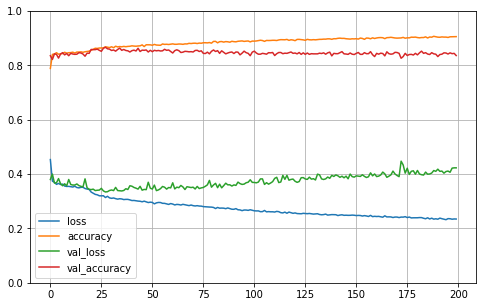

accuracy: 86.65%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4489 - accuracy: 0.7892 - val_loss: 0.3592 - val_accuracy: 0.8330
Epoch 2/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3779 - accuracy: 0.8365 - val_loss: 0.3589 - val_accuracy: 0.8380
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3719 - accuracy: 0.8391 - val_loss: 0.3480 - val_accuracy: 0.8492
Epoch 4/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3620 - accuracy: 0.8445 - val_loss: 0.3475 - val_accuracy: 0.8498
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3633 - accuracy: 0.8439 - val_loss: 0.3550 - val_accuracy: 0.8442
Epoch 6/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3627 - accuracy: 0.8456 - val_loss: 0.3503 - val_accuracy: 0.8504
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3600 - accuracy: 0.84

453/453 [==============================] - 1s 2ms/step - loss: 0.2977 - accuracy: 0.8761 - val_loss: 0.3351 - val_accuracy: 0.8585
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2982 - accuracy: 0.8762 - val_loss: 0.3301 - val_accuracy: 0.8597
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2988 - accuracy: 0.8744 - val_loss: 0.3324 - val_accuracy: 0.8566
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2960 - accuracy: 0.8734 - val_loss: 0.3399 - val_accuracy: 0.8572
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2947 - accuracy: 0.8768 - val_loss: 0.3509 - val_accuracy: 0.8510
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2978 - accuracy: 0.8749 - val_loss: 0.3301 - val_accuracy: 0.8572
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2957 - accuracy: 0.8735 - val_loss: 0.3324 - val_accuracy: 0.8616
Epoch

Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2648 - accuracy: 0.8909 - val_loss: 0.3701 - val_accuracy: 0.8448
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2633 - accuracy: 0.8921 - val_loss: 0.3660 - val_accuracy: 0.8492
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2648 - accuracy: 0.8904 - val_loss: 0.3704 - val_accuracy: 0.8529
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2618 - accuracy: 0.8917 - val_loss: 0.3676 - val_accuracy: 0.8473
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2615 - accuracy: 0.8911 - val_loss: 0.3813 - val_accuracy: 0.8336
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2604 - accuracy: 0.8937 - val_loss: 0.3700 - val_accuracy: 0.8510
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2593 - accuracy: 0.8937 - val_loss: 0.3533 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.2402 - accuracy: 0.9011 - val_loss: 0.3860 - val_accuracy: 0.8547
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2409 - accuracy: 0.9018 - val_loss: 0.3954 - val_accuracy: 0.8504
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2389 - accuracy: 0.9006 - val_loss: 0.3941 - val_accuracy: 0.8529
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2380 - accuracy: 0.9021 - val_loss: 0.4334 - val_accuracy: 0.8423
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2375 - accuracy: 0.9031 - val_loss: 0.4056 - val_accuracy: 0.8411
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2376 - accuracy: 0.9033 - val_loss: 0.4167 - val_accuracy: 0.8523
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2368 - accuracy: 0.9026 - val_loss: 0.4172 - val_accuracy: 0.8535

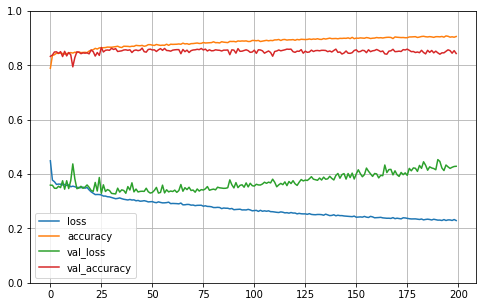

accuracy: 86.59%

5-way Cross Validation mean 86.80% (+/- 0.82%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")